In [1]:
import qiime2 as q2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (precision_score, recall_score, precision_recall_curve, auc)
%matplotlib inline

In [2]:
load_path = '/Users/bec5786/Desktop/temp/joint_ctf_out/'

### KNN + AUC PR

In [3]:
#load subject loadings
#case 1: gut + skin joint decomposition
integration = 'Gut-Skin'
joint1_gut = pd.read_csv('{}mod2/CSseed_false/loadings/{}_Gut_subject_loadings_all.tsv'.format(load_path, integration), 
                         sep='\t', index_col=0)
joint1_skin = pd.read_csv('{}mod2/CSseed_false/loadings/{}_Skin_subject_loadings_all.tsv'.format(load_path, integration), 
                         sep='\t', index_col=0)
single1_gut = pd.read_csv('{}mod1/CSseed_false/loadings/Gut_subject_loadings_all.tsv'.format(load_path), sep='\t', index_col=0)
single1_skin = pd.read_csv('{}mod1/CSseed_false/loadings/Skin_subject_loadings_all.tsv'.format(load_path), sep='\t', index_col=0)

#case 2: gut + oral joint decomposition
integration = 'Gut-Mouth'
joint2_gut = pd.read_csv('{}mod2/CSseed_false/loadings/{}_Gut_subject_loadings_all.tsv'.format(load_path, integration), 
                         sep='\t', index_col=0)
joint2_mouth = pd.read_csv('{}mod2/CSseed_false/loadings/{}_Oral_subject_loadings_all.tsv'.format(load_path, integration), 
                         sep='\t', index_col=0)
single2_gut = pd.read_csv('{}mod1/CSseed_false/loadings/Gut-Mouth_subject_loadings_all.tsv'.format(load_path), sep='\t', index_col=0)
single2_mouth = pd.read_csv('{}mod1/CSseed_false/loadings/Mouth-Gut_subject_loadings_all.tsv'.format(load_path), sep='\t', index_col=0)

In [4]:
# load filtered tables
csseed = False
body_site = 'Baby-Feces'
mf1 = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)

body_site = 'Baby-Forearm'
mf2 = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)

if csseed == False:
    mf1 = mf1[mf1.birth_mode_ms != 'CSseed']
    mf2 = mf2[mf2.birth_mode_ms != 'CSseed']

#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep1 = mf1[subject_id_column].value_counts()[mf1[subject_id_column].value_counts() > 1].index
mf1 = mf1[mf1[subject_id_column].isin(ids_to_keep1)]

ids_to_keep2 = mf2[subject_id_column].value_counts()[mf2[subject_id_column].value_counts() > 1].index
mf2 = mf2[mf2[subject_id_column].isin(ids_to_keep2)]

##2 modalities
#ensure subjects are shared across modalities
shared_subjects = [s_id for s_id in mf1.subjectid_unique.unique() if s_id in mf2.subjectid_unique.unique()]
print("# shared subjects: {}".format(len(shared_subjects)))
mf1 = mf1[mf1.subjectid_unique.isin(shared_subjects)]
mf2 = mf2[mf2.subjectid_unique.isin(shared_subjects)]
#sanity check
print(len(mf1.subjectid_unique.unique()))
print(len(mf2.subjectid_unique.unique()))

# shared subjects: 71
71
71


In [6]:
# cat_of_interest = 'birth_mode_ms'
# baby_combined_mf = pd.concat([mf1, mf2])
# mf_all = baby_combined_mf.groupby('subjectid_unique').agg({cat_of_interest:'first',
#                                                            'country':'first'})

In [11]:
cat_of_interest = 'birth_mode_ms'
n_splits = 5
mf_collapsed = mf1.groupby(subject_id_column).agg({cat_of_interest:'first'})
metrics_df = pd.DataFrame(columns=['AUC_APR', 'Group'])

for ind_loads, seed, group in zip([single1_gut, single1_skin, joint1_gut],
                                  [100,200,300], 
                                  ['Gut_Separate', 'Skin_Separate', 'Gut-Skin_Joint-CTF']):
    print(group)
    #set up the classifier
    knn = KNeighborsClassifier(n_neighbors=2)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    X = ind_loads[['component_1', 'component_2', 'component_3']].copy()
    y = X.index.map(mf_collapsed[cat_of_interest])
    X = X.values

    apr_lst = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        y_proba = knn.predict_proba(X_test)
        
        y_test_binary = [0 if x == "Vag" else 1 for x in y_test]
        y_pred_binary = [0 if x == "Vag" else 1 for x in y_pred]

        #precision = precision_score(y_test_binary, y_pred_binary, average='binary')
        #recall = recall_score(y_test_binary, y_pred_binary, average='binary')
        precision, recall, _ = precision_recall_curve(y_test_binary, y_proba[:,0])

        #PR AUC
        auc_pr = auc(x=recall, y=precision)
        apr_lst.append(auc_pr)
    
    #create df with metrics
    metrics_df_iter = pd.DataFrame({'AUC_APR':apr_lst}, index=range(n_splits))
    metrics_df_iter['Group'] = group

    #stack the metrics
    metrics_df = pd.concat([metrics_df, metrics_df_iter])

Gut_Separate
Skin_Separate
Gut-Skin_Joint-CTF


/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken wil

(15, 2)


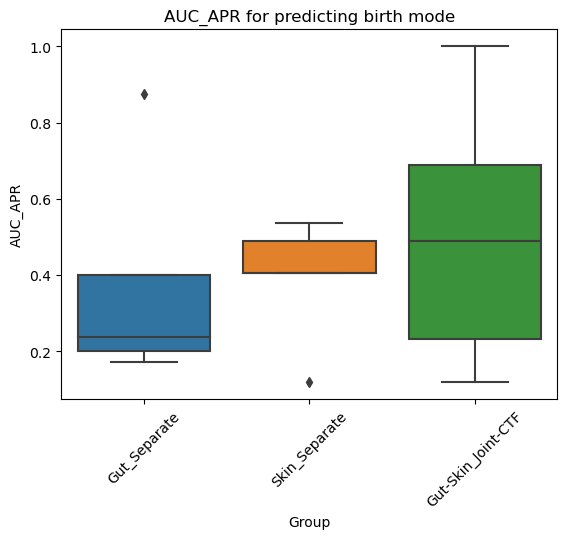

In [12]:
#plot the results
print(metrics_df.shape)
fig, ax = plt.subplots()
ax = sns.boxplot(x='Group', y='AUC_APR', data=metrics_df)
plt.xticks(rotation=45)
plt.title('AUC_APR for predicting birth mode')
plt.show()

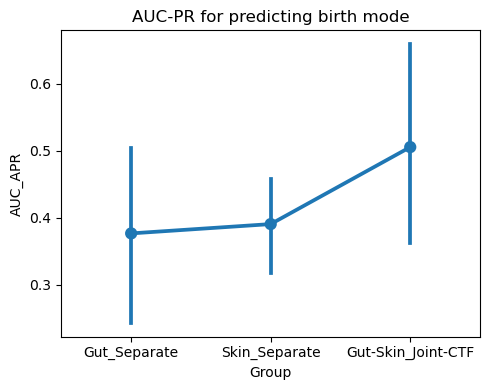

In [13]:
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(x='Group', y='AUC_APR', data=metrics_df, ax=ax, errorbar=('ci', 68))
plt.title('AUC-PR for predicting birth mode')
plt.tight_layout()
plt.show()

### Features

In [11]:
# load taxa 
taxa = q2.Artifact.load('/Users/bec5786/Desktop/temp/taxonomy.qza')
taxa = taxa.view(pd.DataFrame)

In [12]:
##compare top features in one-mod vs two-mod decomposition
component = 'PC1'
#load one-mod decomposition and stack
top5_gut_individual = pd.read_csv('{}mod1/CSseed_false/log_ratio_features/Gut_top5_features_{}_all.txt'.format(load_path, component), sep='\t')
bottom5_gut_individual = pd.read_csv('{}mod1/CSseed_false/log_ratio_features/Gut_bottom5_features_{}_all.txt'.format(load_path, component), sep='\t')
gut_single1_features = pd.concat([top5_gut_individual, bottom5_gut_individual])

top5_skin_individual = pd.read_csv('{}mod1/CSseed_false/log_ratio_features/Skin_top5_features_{}_all.txt'.format(load_path, component), sep='\t')
bottom5_skin_individual = pd.read_csv('{}mod1/CSseed_false/log_ratio_features/Skin_bottom5_features_{}_all.txt'.format(load_path, component), sep='\t')
skin_single1_features = pd.concat([top5_skin_individual, bottom5_skin_individual])

#load two-mod decomposition
top5_gut_joint = pd.read_csv('{}mod2/CSseed_false/log_ratio_features/Gut-Skin_Gut_top5_features_{}_all.txt'.format(load_path, component), sep='\t')
bottom5_gut_joint = pd.read_csv('{}mod2/CSseed_false/log_ratio_features/Gut-Skin_Gut_bottom5_features_{}_all.txt'.format(load_path, component), sep='\t')
gut_joint1_features = pd.concat([top5_gut_joint, bottom5_gut_joint])

top5_skin_joint = pd.read_csv('{}mod2/CSseed_false/log_ratio_features/Gut-Skin_Skin_top5_features_{}_all.txt'.format(load_path, component), sep='\t')
bottom5_skin_joint = pd.read_csv('{}mod2/CSseed_false/log_ratio_features/Gut-Skin_Skin_bottom5_features_{}_all.txt'.format(load_path, component), sep='\t')
skin_joint1_features = pd.concat([top5_skin_joint, bottom5_skin_joint])

In [13]:
#map taxa to features
gut_single1_features['Taxon'] = gut_single1_features['featureID'].map(taxa['Taxon'])
gut_single1_features['Confidence'] = gut_single1_features['featureID'].map(taxa['Confidence'])
skin_single1_features['Taxon'] = skin_single1_features['featureID'].map(taxa['Taxon'])
skin_single1_features['Confidence'] = skin_single1_features['featureID'].map(taxa['Confidence'])

gut_joint1_features['Taxon'] = gut_joint1_features['featureID'].map(taxa['Taxon'])
gut_joint1_features['Confidence'] = gut_joint1_features['featureID'].map(taxa['Confidence'])
skin_joint1_features['Taxon'] = skin_joint1_features['featureID'].map(taxa['Taxon'])
skin_joint1_features['Confidence'] = skin_joint1_features['featureID'].map(taxa['Confidence'])

In [14]:
#calculate intersection of top features
gut_shared = set(gut_single1_features.featureID).intersection(gut_joint1_features.featureID)
skin_shared = set(skin_single1_features.featureID).intersection(skin_joint1_features.featureID)
print("# shared gut features: {}".format(len(gut_shared)), gut_single1_features.shape[0])
print("# shared skin features: {}".format(len(skin_shared)), skin_single1_features.shape[0])

# shared gut features: 36 54
# shared skin features: 124 128


In [15]:
#calculate intersection of top features
gut_shared_taxon = list(set(gut_single1_features.Taxon).intersection(gut_joint1_features.Taxon))
skin_shared_taxon = list(set(skin_single1_features.Taxon).intersection(skin_joint1_features.Taxon))
print("# shared gut features: {}".format(len(gut_shared_taxon)), gut_single1_features.shape[0], gut_joint1_features.shape[0])
print("# shared skin features: {}".format(len(skin_shared_taxon)), skin_single1_features.shape[0], skin_joint1_features.shape[0])

# shared gut features: 31 54 54
# shared skin features: 78 128 128


In [16]:
gut_shared_taxon_clean = [taxa.split(';')[-2]+taxa.split(';')[-1] for taxa in gut_shared_taxon]
skin_shared_taxon_clean = [taxa.split(';')[-2]+taxa.split(';')[-1] for taxa in skin_shared_taxon]

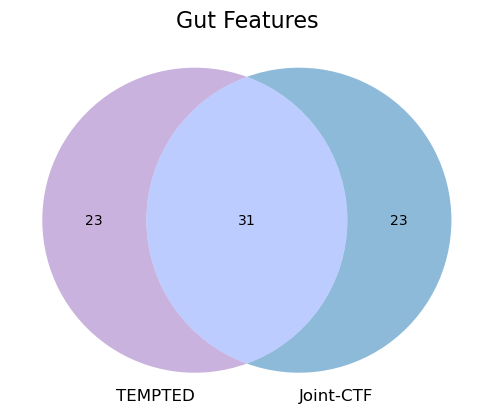

In [17]:
#plot venn diagram
plt.figure()
a = gut_single1_features.shape[0] - len(gut_shared_taxon)
b = len(gut_shared_taxon)
c = gut_joint1_features.shape[0] - len(gut_shared_taxon)

venn2(subsets = (a, c, b),
      set_labels = ('TEMPTED', 'Joint-CTF'),
      set_colors = ('tab:purple', 'tab:blue'), alpha=0.5)
plt.title('Gut Features', fontsize=16)
plt.show()

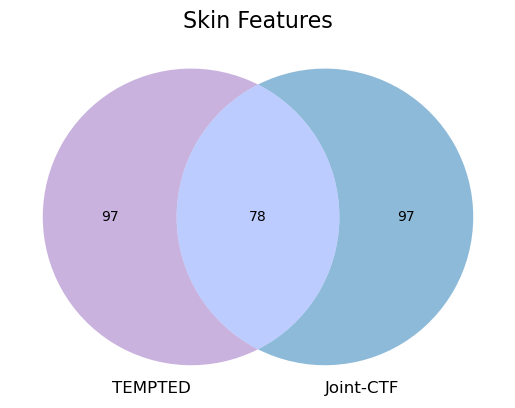

In [18]:
plt.figure()
a = skin_single1_features.shape[0] - len(gut_shared_taxon)
b = len(skin_shared_taxon)
c = skin_joint1_features.shape[0] - len(gut_shared_taxon)

venn2(subsets = (a, c, b),
      set_labels = ('TEMPTED', 'Joint-CTF'),
      set_colors = ('tab:purple', 'tab:blue'), alpha=0.5)
plt.title('Skin Features', fontsize=16)
plt.show()